# Plots for Siggi Paper

### Simple examples of information gain

In [1]:
# First import code
import sys
sys.path.append('..')

In [2]:
from siggi import siggi, filters, spectra, calcIG, plotting
from siggi import Sed
from siggi.lsst_utils import Bandpass, BandpassDict, PhotometricParameters
import matplotlib.pyplot as plt
import numpy as np
import os
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import seaborn as sbs
sbs.set()

### Set up red and blue spectra

In [4]:
f = filters()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

In [5]:
def flat_prior_2(z):
    z_out = np.ones(len(z))
    z_out[0] = 0.
    return z_out

In [6]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [7]:
bp_list = []
bp_dir = '../siggi/data/lsst_baseline_throughputs'
for filter_name in ['u', 'g', 'r', 'i', 'z', 'y']:
    current_bp = Bandpass()
    print(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
    current_bp.readThroughput(os.path.join(bp_dir, 'filter_%s.dat' % filter_name))
    bp_list.append(current_bp)

../siggi/data/lsst_baseline_throughputs/filter_u.dat
../siggi/data/lsst_baseline_throughputs/filter_g.dat
../siggi/data/lsst_baseline_throughputs/filter_r.dat
../siggi/data/lsst_baseline_throughputs/filter_i.dat
../siggi/data/lsst_baseline_throughputs/filter_z.dat
../siggi/data/lsst_baseline_throughputs/filter_y.dat


In [8]:
bp_dict = BandpassDict(bp_list, ['u', 'g', 'r', 'i', 'z', 'y'])

In [9]:
new_phot_params = {}

new_phot_params['filter_0'] = PhotometricParameters(nexp=2, bandpass='any')
new_phot_params['filter_1'] = PhotometricParameters(nexp=2, bandpass='any')

In [10]:
f_norm = red_spec.calcFluxNorm(22., bp_dict['i'])
red_spec.multiplyFluxNorm(f_norm)
f_norm = blue_spec.calcFluxNorm(22., bp_dict['i'])
blue_spec.multiplyFluxNorm(f_norm)

In [11]:
filt_edges = []
for point_loc in point_list:
    filt_edges.append([point_loc[0]-50., point_loc[0]+50., point_loc[1]-50., point_loc[1]+50.])

In [ ]:
ig_vals = []
filt_edges = []
for point_loc in point_list:
    if len(ig_vals) % 50 == 0:
        print('%i out of %i' % (len(ig_vals), len(point_list)))
    filt_new = f.trap_filters([[point_loc[0]-50., point_loc[0]-25., point_loc[0]+25., point_loc[0]+50.],
                               [point_loc[1]-50., point_loc[1]-25., point_loc[1]+25., point_loc[1]+50.]])
    filt_edges.append([point_loc[0]-50., point_loc[0]+50., point_loc[1]-50., point_loc[1]+50.])
    c = calcIG(filt_new, [[red_spec], [blue_spec]], [0.0, 1.0, 1.0], [0, 1, 2], phot_params=new_phot_params, ref_filter=bp_dict['i'], n_pts=10000)
    ig_vals.append(c.calc_IG(rand_state=np.random.RandomState(42)))

### Make plots

In [15]:
max_idx = np.argmax(ig_vals)

best_pt = point_list[max_idx]

In [16]:
best_val = ig_vals[max_idx]

In [17]:
print(best_pt, best_val)

[825.0, 450.0] 0.999999228757


In [18]:
# Uncomment first line if higher wavelength comes first in best_pt
best_pt = [best_pt[1], best_pt[0]]
best_filter = [best_pt[0]-50., best_pt[0]+50., best_pt[1]-50., best_pt[1]+50.]

In [19]:
sig_plot = plotting([red_spec, blue_spec], best_filter,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

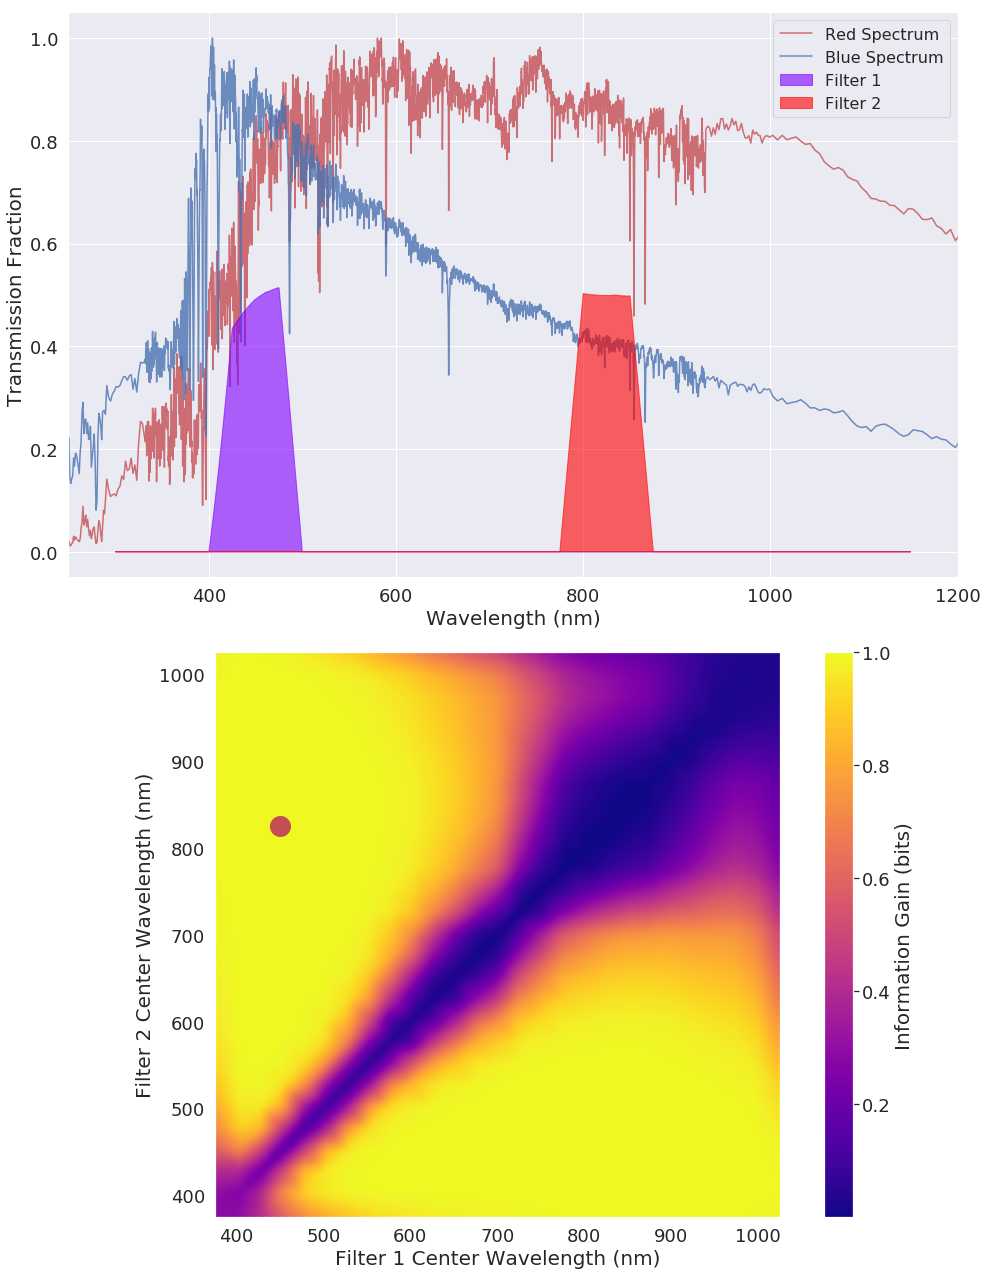

In [20]:
fig = plt.figure(figsize=(14, 18))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax.lines[0].set_color('r')
ax.lines[1].set_color('b')
ax.lines[0].set_alpha(0.8)
ax.lines[1].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Red Spectrum', 'Blue Spectrum', 'Filter 1', 'Filter 2'), loc=1, fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(np.array(filt_edges), np.array(ig_vals), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(best_pt[0], best_pt[1], c='r', s=400)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_1.pdf')

### Make sigmoid filter plot

In [14]:
sig_spec = s.get_sigmoid_spectrum()

In [15]:
sig_spec.wavelen[np.where(sig_spec.flambda < 0.01)] = 0.01

In [16]:
def prior_z(z, z0=0.552):
    return (z**2.)*np.exp(-(z/z0)**2)/(np.sum((np.arange(0, 2.51, .05)**2.)*np.exp(-(np.arange(0, 2.51, .05)/z0)**2.)))

In [17]:
p_cdf = 0
prior_cdf = []
for p_val in np.arange(0.0, 2.51, 0.001):
    p_cdf += prior_z(p_val)
    prior_cdf.append(p_cdf)

(array([-0.01,  0.  ,  0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08]),
 <a list of 10 Text yticklabel objects>)

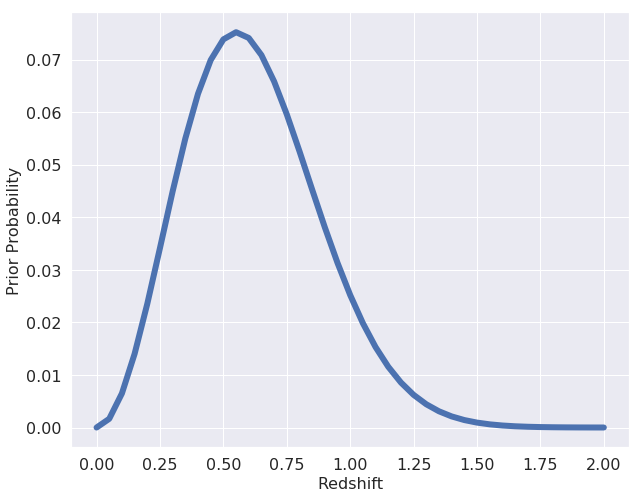

In [18]:
fig = plt.figure(figsize=(10,8))
plt.plot(np.arange(0.00, 2.01, 0.05), prior_z(np.arange(0.00, 2.01, 0.05)), lw=6)
plt.xlabel('Redshift', size=16)
plt.ylabel('Prior Probability', size=16)
plt.xticks(size=16)
plt.yticks(size=16)

In [19]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [20]:
ref_filter = Bandpass()
ref_filter.imsimBandpass()

In [21]:
sig_example = siggi([sig_spec], [1.0], prior_z,# calib_filter=ref_filter,
                    z_min=0.00, z_max=2., z_steps=41, phot_params=new_phot_params, calib_mag=22.)

In [ ]:
%%time
test_rand_state = np.random.RandomState(2325)
num_filters = 2
set_ratio = 0.5
res_2 = sig_example.optimize_filters(num_filters=num_filters,
                                     filt_min=300., filt_max=1100.,
                                     set_ratio=set_ratio,
                                     system_wavelen_max=1200.,
                                     n_opt_points=15,
                                     optimizer_verbosity=5,
                                     procs=1, acq_func_kwargs_dict={'kappa':1.8},
                                     frozen_filt_dict = None,
                                     starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list],
                                     rand_state=test_rand_state)

In [ ]:
min_idx = np.argmin(res_2.yi[:-3])
best_pt = res_2.Xi[min_idx]
print(best_pt, res_2.yi[min_idx])

In [144]:
#np.save('ex2_xi.npy', np.array(res_2.Xi))
#np.save('ex2_yi.npy', np.array(res_2.yi))

In [154]:
#best_pt = [best_pt[0], best_pt[1], best_pt[2], best_pt[3]]

In [159]:
#sig_spec.redshiftSED(0.55)
sig_plot = plotting([sig_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

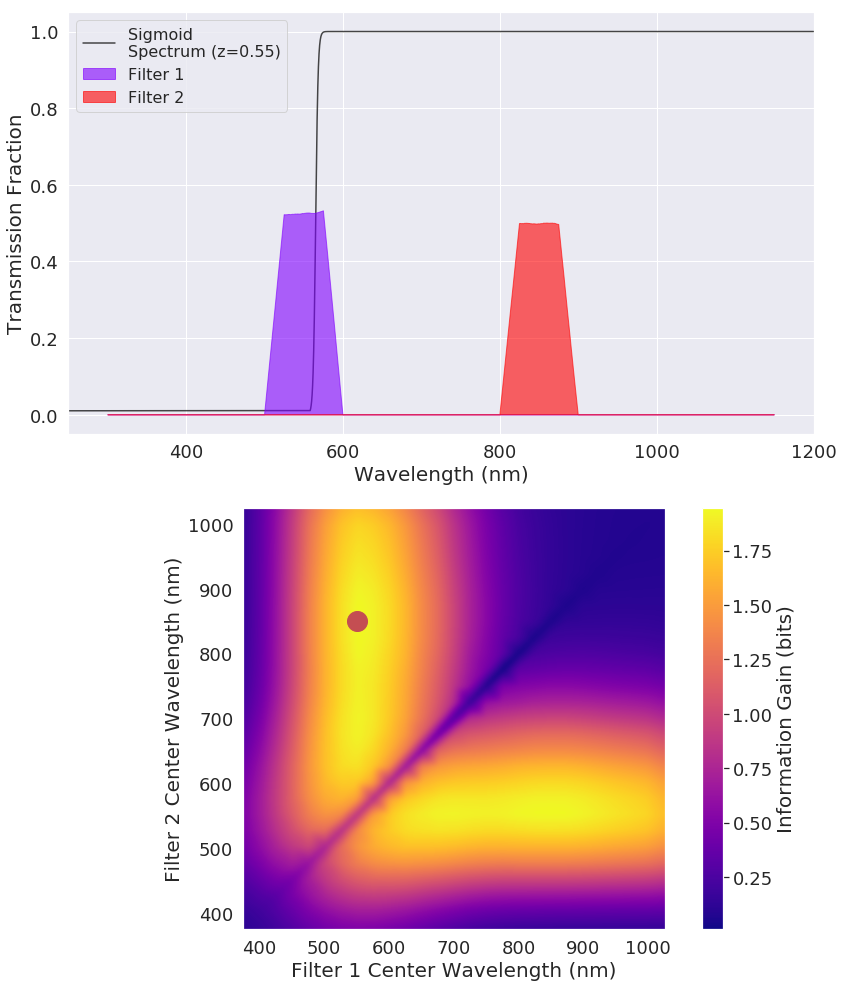

In [175]:
fig = plt.figure(figsize=(12, 14))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax.lines[0].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Sigmoid\nSpectrum (z=0.55)', 'Filter 1', 'Filter 2'), 
           loc=2, fontsize=16)
plt.xticks(size=18)
plt.yticks(size=18)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res_2.Xi[:-3], np.abs(res_2.yi[:-3]), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=400)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_2.pdf')

## Example 3

In [214]:
red_spec = s.get_red_spectrum()

In [177]:
test_red_spec = s.get_red_spectrum()

In [178]:
d_lambda = 25.
x = np.arange(375., 1026., d_lambda)
point_list = []
for val_1 in x:
    for val_2 in x:
        point_list.append([val_1, val_2])
y = np.arange(387.5, 1026., d_lambda)
for val_1 in y:
    point_list.append([val_1, val_1])

In [182]:
sig_example = siggi([red_spec], [1.0], prior_z,
                    z_min=0.00, z_max=2., z_steps=41, phot_params=new_phot_params, calib_mag=22.)

In [183]:
%%time
test_rand_state = np.random.RandomState(864)
num_filters = 2
set_ratio = 0.5
res_3 = sig_example.optimize_filters(num_filters=num_filters,
                                     filt_min=300., filt_max=1100.,
                                     set_ratio=set_ratio,
                                     system_wavelen_max=1200.,
                                     n_opt_points=15,
                                     optimizer_verbosity=5,
                                     procs=1,
                                     frozen_filt_dict = None,
                                     starting_points = [[mid-50., mid+50., mid_2-50., mid_2+50.] for mid, mid_2 in point_list],
                                     rand_state=test_rand_state)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    7.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    9.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 758 out of 758 | elapsed: 30.3min finished


-2.81151686968 758
CPU times: user 4h 33min 42s, sys: 1d 5h 52min 34s, total: 1d 10h 26min 16s
Wall time: 32min 2s


In [184]:
min_idx = np.argmin(res_3.yi[:-3])
best_pt = res_3.Xi[min_idx]
print(best_pt, res_3.yi[min_idx])

[525.0, 625.0, 850.0, 950.0] -2.18514790265


In [185]:
np.where((np.array(res_3.Xi)[:,0] == 425.) & (np.array(res_3.Xi)[:,2] == 475.))#[425., 525., 475., 575.])

(array([114]),)

In [186]:
res_3.yi[114]

-0.45948913436036554

In [187]:
# Uncomment if blue and red filters are reversed
#best_pt = [best_pt[2], best_pt[3], best_pt[0], best_pt[1]]

In [215]:
#red_spec.redshiftSED(0.55)
sig_plot = plotting([test_red_spec, red_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)

In [205]:
#np.save('ex3_xi.npy', np.array(res_3.Xi))
#np.save('ex3_yi.npy', np.array(res_3.yi))

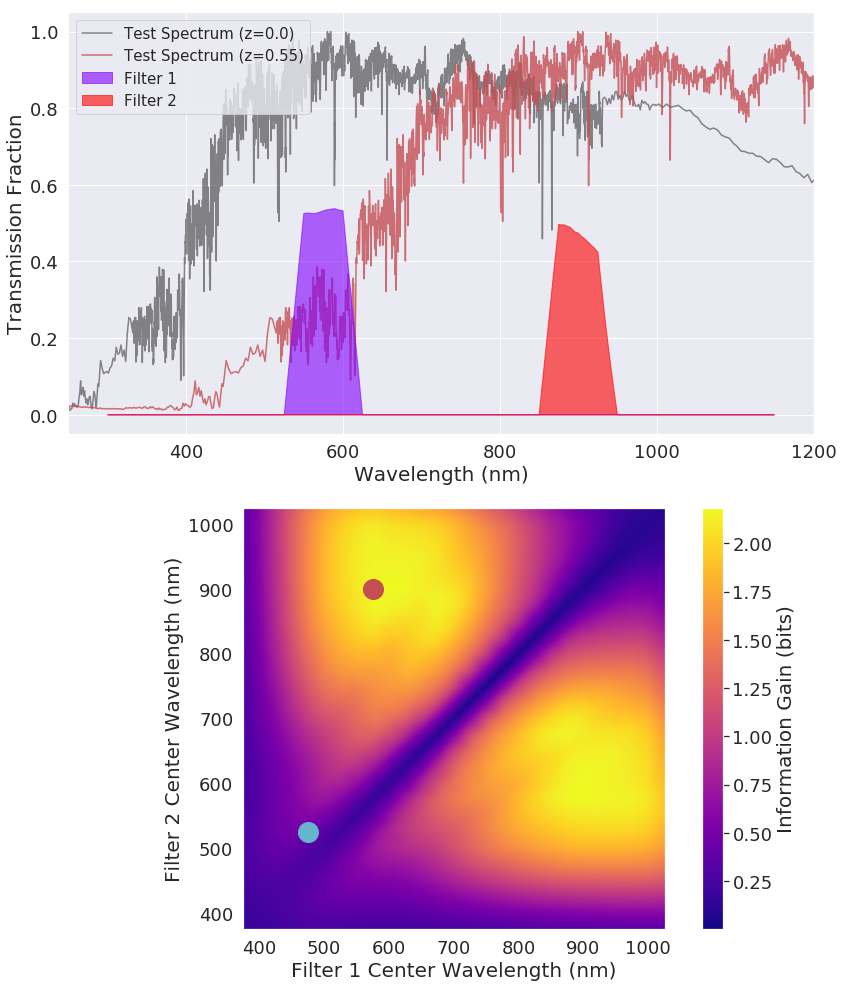

In [216]:
fig = plt.figure(figsize=(12, 14))
fig.add_subplot(2,1,1)
sig_plot.plot_filters(fig=fig)
ax = plt.gca()
ax = plt.gca()
#ax.lines[0].set_color('r')
ax.lines[1].set_color('r')
#ax.lines[0].set_alpha(0.8)
ax.lines[1].set_alpha(0.8)
plt.xlabel('Wavelength (nm)', size=20)
plt.ylabel('Transmission Fraction', size=20)
plt.legend(('Test Spectrum (z=0.0)', 'Test Spectrum (z=0.55)', 'Filter 1', 'Filter 2'), loc=2, fontsize=15)
plt.xticks(size=18)
plt.yticks(size=18)
fig.add_subplot(2,1,2)
plt.rcParams.update({'font.size': 16})
sig_plot.plot_ig_space(res_3.Xi[:-3], np.abs(res_3.yi[:-3]), [0,1])
cbar = plt.colorbar()
cbar.set_label('Information Gain (bits)', size=20)
cbar.ax.tick_params(labelsize=18)
plt.scatter(best_pt[0]+50., best_pt[2]+50., c='r', s=400)
plt.scatter(475., 525., c='c', s=400)
plt.xlabel('Filter 1 Center Wavelength (nm)', size=20)
plt.ylabel('Filter 2 Center Wavelength (nm)', size=20)
plt.xticks(size=18)
plt.yticks(size=18)
plt.grid(False)
plt.tight_layout()
#plt.savefig('Example_3.pdf')

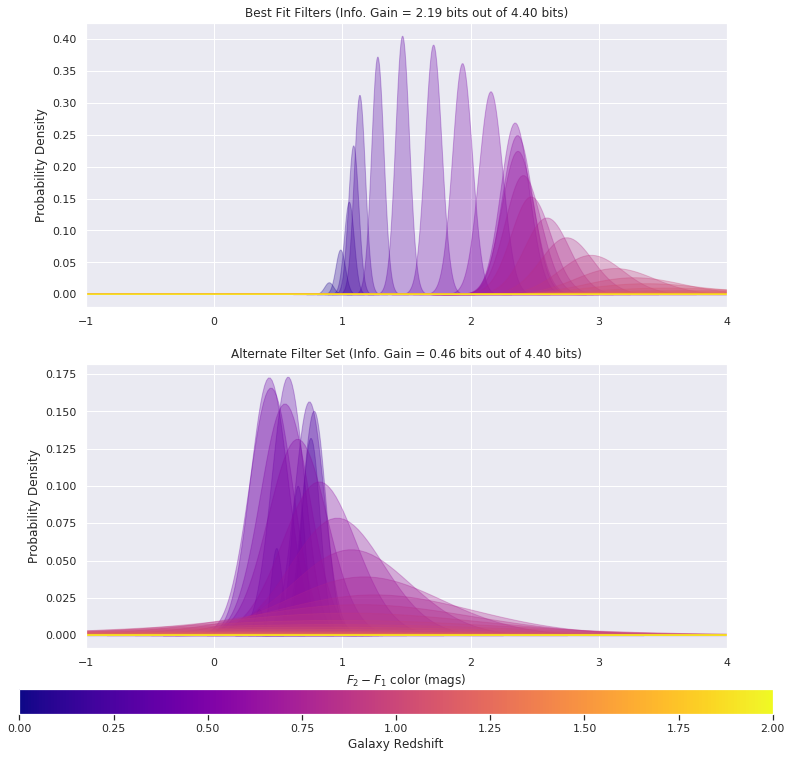

In [213]:
fig = plt.figure(figsize=(11.5, 11.5))
fig.add_subplot(2,1,1)
sig_plot = plotting([red_spec], best_pt,
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)
fig = sig_plot.plot_color_distributions(['filter_0', 'filter_1'], np.linspace(0, 2., 41), fig=fig,
                                       include_prior=prior_z)#,add_cbar=True)
#plt.xlabel(r'$F_{2} - F_{1}$ color (mags)')
plt.xlabel('')
plt.xlim(-1,4)
plt.title('Best Fit Filters (Info. Gain = 2.19 bits out of 4.40 bits)')
fig.add_subplot(2,1,2)
sig_plot = plotting([red_spec], [425., 525., 475., 575.],
                    frozen_filt_dict=None, set_ratio=0.5,
                    sed_mags=22.0)
fig = sig_plot.plot_color_distributions(['filter_0', 'filter_1'], np.linspace(0, 2., 41),
                                       include_prior=prior_z, fig=fig)#,add_cbar=True)
plt.xlim(-1,4)
plt.xlabel(r'$F_{2} - F_{1}$ color (mags)')
plt.title('Alternate Filter Set (Info. Gain = 0.46 bits out of 4.40 bits)')
#plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap = plt.cm.plasma, norm=plt.Normalize(vmin=0., vmax=2.))
sm._A = []
new_ax = fig.add_axes([0.045, 0.045, 0.91, 0.03])
cbar = plt.colorbar(sm, cax=new_ax, orientation='horizontal')
cbar.set_label('Galaxy Redshift')
plt.savefig('example_3_color_plot_w_prior.png')